In [17]:
import time
import math
from keras.models import Sequential
from tensorflow.keras.layers import  LSTM,Dense, Dropout,Activation
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### Import Data

In [18]:
data = pd.read_csv('nyse_2001-2021.csv')
df=data
df.head()


,Date,Low,Open,Volume,High,Close,Adjusted Close
0,29-11-2001,13.360000,13.386667,371100,14.466667,13.880000,12.583543
1,30-11-2001,13.880000,13.880000,165300,14.266667,14.266667,12.934094
2,03-12-2001,13.783333,14.233333,127500,14.233333,13.783333,12.495903
3,04-12-2001,13.233333,13.783333,95400,13.783333,13.233333,11.997280
4,05-12-2001,13.433333,13.433333,598200,14.783333,14.666667,13.296731


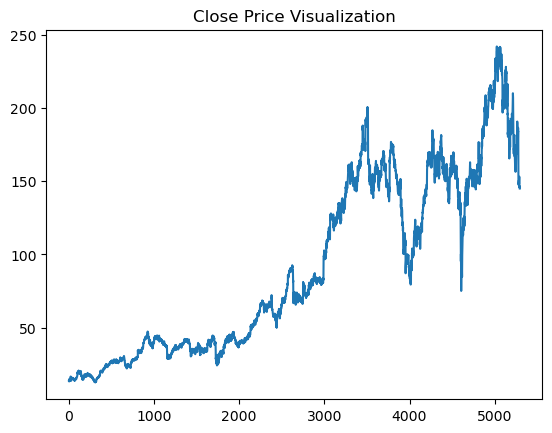

In [19]:
plt.title("Close Price Visualization")
plt.plot(df.Close)

### Defining 200 days moving averages and plotting comparision graph with 100 days moving averages

In [20]:
ma100 = df.Close.rolling(100).mean()
ma100



0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5291    176.1565
5292    175.7703
5293    175.3297
5294    174.8621
5295    174.4132
Name: Close, Length: 5296, dtype: float64

Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days')

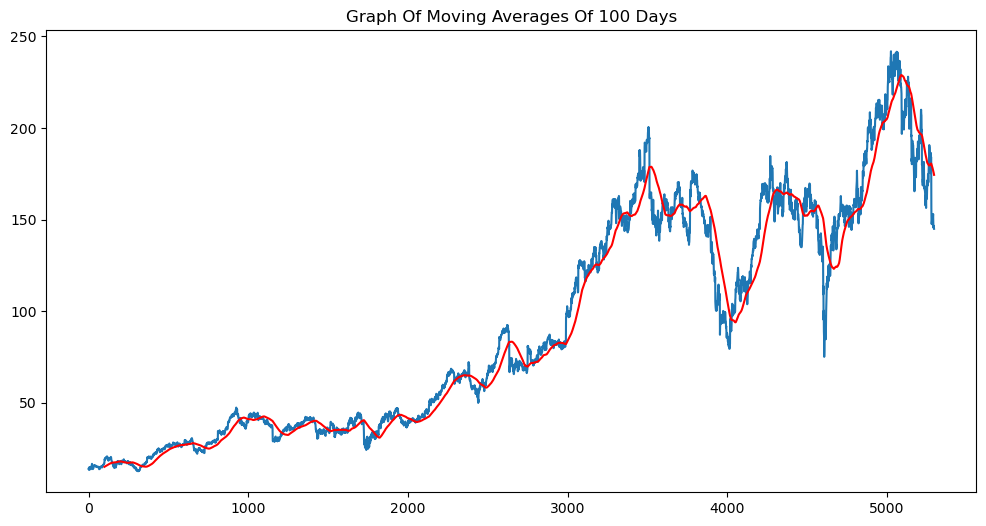

In [21]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.title('Graph Of Moving Averages Of 100 Days')

In [22]:
ma200 = df.Close.rolling(200).mean()
ma200

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
5291    187.62320
5292    187.32265
5293    187.07160
5294    186.79705
5295    186.49390
Name: Close, Length: 5296, dtype: float64

Text(0.5, 1.0, 'Comparision Of 100 Days And 200 Days Moving Averages')

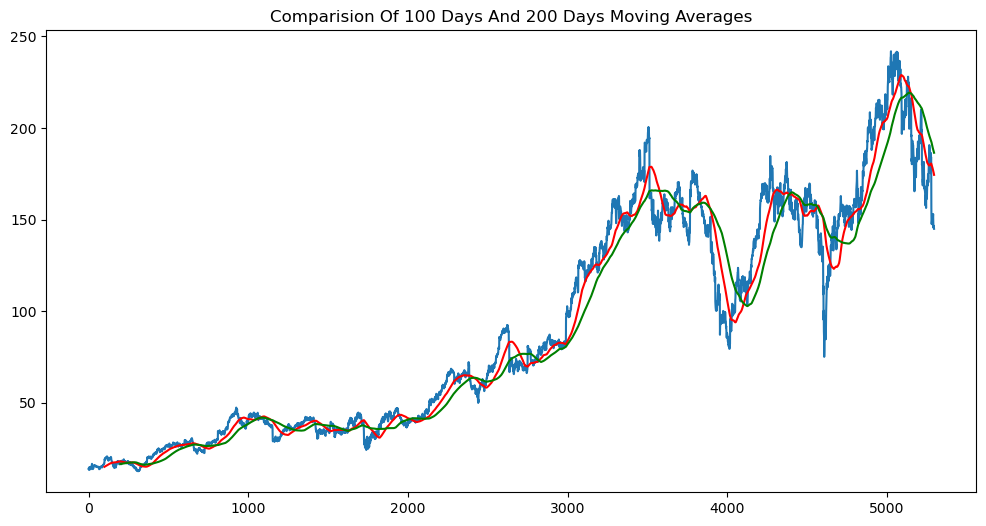

In [23]:

plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.title('Comparision Of 100 Days And 200 Days Moving Averages')

### Data preprocessing

In [24]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Use only the "Close" column for simplicity
close_prices = data['Close'].values.reshape(-1, 1)


C:\Users\stella\AppData\Local\Temp\ipykernel_25496\2175890208.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'])


In [25]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

#### Splitting data into train, validation, test dataset.


In [26]:
N = 100  # use the past 100 days data
M=5 # predict the next 5 days data
# Create sequences
def create_sequences(data, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i + N])
        y.append(data[i + N:i + N + M])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, N, M)

# Split into train, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Reshape for LSTM (samples, timesteps, features)
y_train = y_train.reshape(-1, M)
y_val = y_val.reshape(-1, M)
y_test = y_test.reshape(-1, M)

In [27]:
y_train.shape

(3634, 5)

### Creating LSTM Model

In [28]:
# LSTM architecture

model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True
              ,input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))


model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.2))


model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))


model.add(LSTM(units = 100, activation = 'relu'))
model.add(Dropout(0.4))

model.add(Dense(units = 1))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               7

#### Training the model


In [31]:
# Train the final model using the best hyperparameters

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['MAE'])

history =model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=256,
    epochs=30,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/30
15/15 [==============================] - 46s 2s/step - loss: 0.0581 - MAE: 0.1742 - val_loss: 0.0316 - val_MAE: 0.1617
Epoch 2/30
15/15 [==============================] - 22s 1s/step - loss: 0.0115 - MAE: 0.0796 - val_loss: 0.0177 - val_MAE: 0.1233
Epoch 3/30
15/15 [==============================] - 23s 2s/step - loss: 0.0061 - MAE: 0.0508 - val_loss: 0.0029 - val_MAE: 0.0445
Epoch 4/30
15/15 [==============================] - 23s 2s/step - loss: 0.0038 - MAE: 0.0406 - val_loss: 0.0028 - val_MAE: 0.0419
Epoch 5/30
15/15 [==============================] - 23s 2s/step - loss: 0.0034 - MAE: 0.0372 - val_loss: 0.0034 - val_MAE: 0.0466
Epoch 6/30
15/15 [==============================] - 23s 2s/step - loss: 0.0031 - MAE: 0.0340 - val_loss: 0.0029 - val_MAE: 0.0425
Epoch 7/30
15/15 [==============================] - 24s 2s/step - loss: 0.0027 - MAE: 0.0320 - val_loss: 0.0024 - val_MAE: 0.0388
Epoch 8/30
15/15 [==============================] - 25s 2s/step - loss: 0.0026 - MAE: 0.03

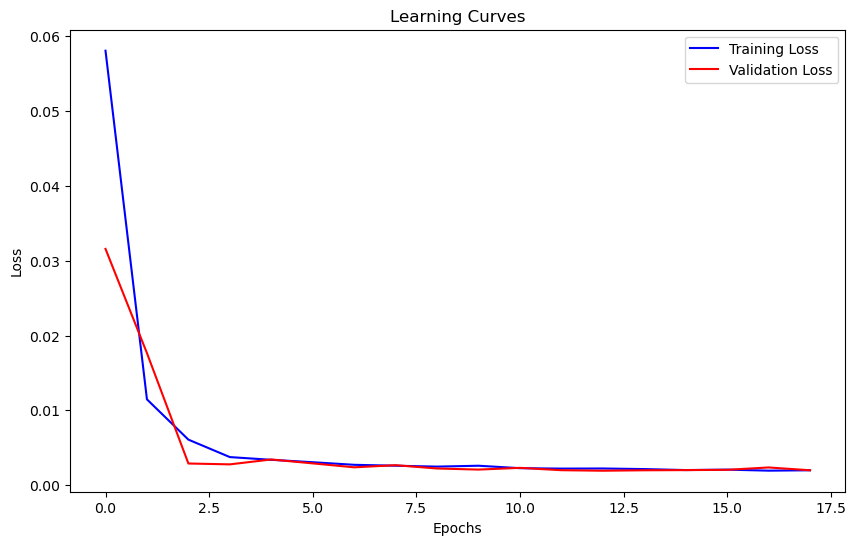

In [32]:
# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

#### Testing the model


In [33]:
# Making predictions
# Evaluate the model on the test data using
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])


Evaluate on test data
25/25 [==============================] - 1s 56ms/step - loss: 0.0035 - MAE: 0.0474
Test MSE: 0.003459867089986801
Test MAE: 0.04744316637516022


### Predictions

In [36]:
y_pred = model.predict(X_test)

25/25 [==============================] - 1s 49ms/step


In [37]:
# Inverse scale predictions
y_test_scaled = scaler.inverse_transform(y_test)
y_pred_scaled = scaler.inverse_transform(y_pred)

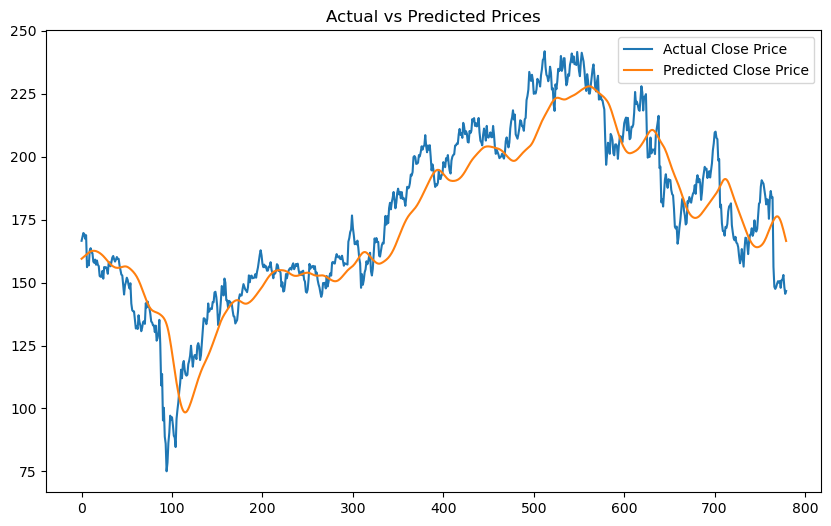

In [39]:


plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled[:,1], label='Actual Close Price ')  # Close price index
plt.plot(y_pred_scaled, label='Predicted Close Price')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.show()